# 41-kmeans-clustering-with-votes
> In this notebook, I am going to perform K-means clustering with votes column.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path
import glob

from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Import Data

For the first stpe, we need to import data. If you want to run this code in your local computer, please change the path of "personal_path" corresponding to your local environment.

In [3]:
# Define file paths
prefix_path = os.path.expanduser('~/')
# If you want to run this code, please edit personal path below.
personal_path = 'Vanderbilt University/2021 Fall/'
folder_path = 'case2/Data/cluster16_kmode/'
path = prefix_path + personal_path + folder_path

# Import all csv file in the cluster16_kmode folder.
csv_files = glob.glob(path + "*.csv")

In [4]:
csv_files[:5]

['/Users/soyeon/Vanderbilt University/2021 Fall/case2/Data/cluster16_kmode/UK, USA_English_James Ivory_Drama.csv',
 '/Users/soyeon/Vanderbilt University/2021 Fall/case2/Data/cluster16_kmode/USA_English_Tobe Hooper_Horror.csv',
 '/Users/soyeon/Vanderbilt University/2021 Fall/case2/Data/cluster16_kmode/USA_English_Albert Pyun_Action.csv',
 '/Users/soyeon/Vanderbilt University/2021 Fall/case2/Data/cluster16_kmode/USA_English, German_Tim Blake Nelson_Drama.csv',
 '/Users/soyeon/Vanderbilt University/2021 Fall/case2/Data/cluster16_kmode/Australia_English_Alex Proyas_Comedy.csv']

Let's import all csv files and save this in "df_list". By doing this, we can call every csv files quickly and it helps us handle many data easily.

In [5]:
# Import dataframe and assign them to a list
df_list = []
for i in range(len(csv_files)):
    df_list.append(pd.read_csv(csv_files[i]))

let's create a new column "group". This value is refers to a group number after we diveded the data using Kmode in the previous notebook 40.

In [6]:
for i in range(len(df_list)):
    df_list[i]['group'] = i + 1

Now, let's combine all dataframe. The reason why we are combining all data together is because we are going to normalize data. 

In [7]:
# Merging multiple dataframes
df_total = [df_list[0], df_list[1],df_list[2], df_list[3], df_list[4], df_list[5], df_list[6], df_list[7], df_list[8], df_list[9], df_list[10], df_list[11], df_list[12], df_list[13], df_list[14], df_list[15]]
all_df = pd.concat(df_total)

In [8]:
all_df.head()

,id,review_1st,review_2nd,description_1st,description_2nd,overview_1st,overview_2nd,votes,reviews_from_critics,popularity,recommendation1,recommendation2,recommendation3,recommendation4,recommendation5,recommendation6,group
0,tt0248123,5.052363,14.008677,19.101181,-5.684755,10.454543,5.274888,6.60,7.0,0.041677,NaN,NaN,NaN,NaN,NaN,NaN,1
1,tt0443584,0.486805,11.690599,20.577621,-4.113286,13.450911,1.172032,4.45,10.0,5.257142,tt0082054,NaN,NaN,NaN,NaN,NaN,1
2,tt0242527,2.242022,11.166927,21.120935,-2.160072,9.920180,0.142537,6.30,47.0,4.406514,tt0366627,NaN,NaN,NaN,NaN,NaN,1
3,tt0374180,5.129464,9.997657,18.254795,-2.657217,10.732504,1.921588,5.35,33.0,8.643620,tt0100369,tt0115610,NaN,NaN,NaN,NaN,1
4,tt0428856,4.142411,12.404982,19.261920,-5.632376,12.010869,2.989712,6.40,40.0,5.545420,tt0415932,NaN,NaN,NaN,NaN,NaN,1


Sanity check! I just want to make sure that the sizes of before merging dataframe and after merging dataframes are same.

In [9]:
sum = 0
for i in range(len(df_list)):
    length = len(df_list[i])
    sum = sum + length
    
sum == all_df.shape[0]

True

Yay! There was no error in the merging process. From now on, let's work on k-means clustering.

# Pre-processing dataframe

When we do K-means clustering, we do not need 'recommendation1','recommendation2','recommendation3','recommendation4','recommendation5','recommendation6' columns. Let's remove these6 columns.

In [10]:
all_df = all_df.drop(['recommendation1','recommendation2','recommendation3','recommendation4','recommendation5','recommendation6'], axis = 1)

In addition, K-means clustering cannot handle NA values. Let's see if there is any value in our dataframe.

In [11]:
all_df_with_na = all_df[all_df.isna().any(axis=1)]
all_df_with_na.shape[0]

14

So there are 14 rows having no values. Let's see where they are missing values.

In [12]:
all_df_with_na

,id,review_1st,review_2nd,description_1st,description_2nd,overview_1st,overview_2nd,votes,reviews_from_critics,popularity,group
95,tt0246425,1.843423,12.641877,18.170963,-4.066043,11.747042,3.375291,6.20,NaN,0.162737,1
5,tt0442781,2.853652,12.622983,20.134197,-2.426526,12.102900,4.626698,6.60,NaN,0.482527,3
132,tt0043852,3.557673,9.072095,21.817322,-3.754801,12.169914,0.555560,5.90,NaN,0.402496,7
227,tt0906783,4.616404,11.496752,19.539680,-5.075519,10.741877,3.472194,7.30,NaN,0.040054,7
27,tt0103790,2.158221,13.711840,18.716960,-1.695146,10.125394,4.529176,7.30,NaN,0.395425,8
102,tt0370919,3.468309,13.875828,17.716330,-2.600512,10.364722,5.006271,5.60,NaN,0.353403,8
41,tt0238119,2.866115,12.060285,19.895515,-2.652584,10.396688,4.879060,7.55,NaN,1.016074,9
215,tt0033368,5.709056,12.823380,18.577253,-4.927560,12.052207,3.015317,2.95,NaN,0.136618,9
281,tt0100100,4.451709,11.838080,17.702955,-0.597473,8.045263,2.611479,3.45,NaN,0.040273,9
768,tt0253614,4.859054,12.361036,18.347586,-4.458643,-7.989658,2.430631,8.60,NaN,1.115787,9


There are 14 rows not having the value in 'eviews_from_critics' column. Since our recommendation system is based on content, every data has to be a "fact". For this reason, I am going to remove these 14 rows.

In [13]:
# Remove all rows having NA values.
all_df = all_df.dropna()

In [14]:
all_df.head()

,id,review_1st,review_2nd,description_1st,description_2nd,overview_1st,overview_2nd,votes,reviews_from_critics,popularity,group
0,tt0248123,5.052363,14.008677,19.101181,-5.684755,10.454543,5.274888,6.60,7.0,0.041677,1
1,tt0443584,0.486805,11.690599,20.577621,-4.113286,13.450911,1.172032,4.45,10.0,5.257142,1
2,tt0242527,2.242022,11.166927,21.120935,-2.160072,9.920180,0.142537,6.30,47.0,4.406514,1
3,tt0374180,5.129464,9.997657,18.254795,-2.657217,10.732504,1.921588,5.35,33.0,8.643620,1
4,tt0428856,4.142411,12.404982,19.261920,-5.632376,12.010869,2.989712,6.40,40.0,5.545420,1


In [15]:
all_df.shape

(3023, 11)

After removing 14 movies, 3023 movies left.

# Normalization

K-means clustering is based on the distance between data point's features. For this reason, normalization is very important for K-means clustering. I am going to use min-max normalization to each column. After this process, values will be between 0 to 1.

In [16]:
def normalize(df):
    """
    Normalize all values in dataframe
    
    Parameters
    ----------
    df : dataframe
        a dataframe we want to normalize
        
    Returns
    -------
    df 
        a normalized dataframe
    """
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

When we do noramlization, we want to normalize only features. So let's remove 'id' and 'group' temporariliy.

In [17]:
all_df_id = all_df[['id', 'group']]
left_over = all_df.drop(['id', 'group'], axis = 1)

In [18]:
# Perform normalization
df_norm = normalize(left_over)

In [19]:
df_norm.head()

,review_1st,review_2nd,description_1st,description_2nd,overview_1st,overview_2nd,votes,reviews_from_critics,popularity
0,0.809561,0.784496,0.450726,0.026841,0.841725,0.437456,0.738854,0.008197,0.000225
1,0.119524,0.424670,0.662225,0.261958,0.978468,0.143147,0.464968,0.012295,0.028406
2,0.384807,0.343383,0.740054,0.554190,0.817338,0.069299,0.700637,0.062842,0.023810
3,0.821214,0.161882,0.329482,0.479809,0.854410,0.196915,0.579618,0.043716,0.046704
4,0.672031,0.535561,0.473752,0.034677,0.912749,0.273534,0.713376,0.053279,0.029964


We've done normalization! Let's put 'id' and 'group' back to the dataframe.

In [20]:
df_temp = pd.concat([all_df_id, df_norm], axis = 1)

In [21]:
df_temp.head(10)

,id,group,review_1st,review_2nd,description_1st,description_2nd,overview_1st,overview_2nd,votes,reviews_from_critics,popularity
0,tt0248123,1,0.809561,0.784496,0.450726,0.026841,0.841725,0.437456,0.738854,0.008197,0.000225
1,tt0443584,1,0.119524,0.424670,0.662225,0.261958,0.978468,0.143147,0.464968,0.012295,0.028406
2,tt0242527,1,0.384807,0.343383,0.740054,0.554190,0.817338,0.069299,0.700637,0.062842,0.023810
3,tt0374180,1,0.821214,0.161882,0.329482,0.479809,0.854410,0.196915,0.579618,0.043716,0.046704
4,tt0428856,1,0.672031,0.535561,0.473752,0.034677,0.912749,0.273534,0.713376,0.053279,0.029964
5,tt0073233,1,0.142720,0.395430,0.648675,0.274619,0.973781,0.195054,0.745223,0.023224,0.001876
6,tt0384177,1,0.312575,0.496122,0.320774,0.701450,0.870247,0.338801,0.636943,0.030055,0.003271
7,tt0072933,1,0.135215,0.422772,0.441108,0.067454,0.971635,0.283054,0.515924,0.031421,0.018785
8,tt0002461,1,0.484374,0.370555,0.313490,0.598441,0.807931,0.288894,0.248408,0.000000,0.000277
9,tt0337876,1,0.407907,0.237194,0.775982,0.300408,0.936475,0.252804,0.662420,0.236339,0.036588


# Seperate dataframe by group # from K-modes.
We want to perform K-means clustering within K-modes groups. Therefore, let's seperate the dataframe by group # from K-modes. Since we have 16 groups after K-modes, I am expecting the result will be 16 dataframes.

In [22]:
final_df_list = []

group_list = df_temp["group"].unique()
megadata_groupby_id =df_temp.groupby('group')
for i in range(len(df_list)):
    final_df_list.append(megadata_groupby_id.get_group(i+1))

In [23]:
for i in range(len(final_df_list)): 
    final_df_list[i].reset_index(drop=True, inplace=True)

In [24]:
len(final_df_list)

16

# Clustering

In [25]:
def kmeans_elbow_plot(i):
    """
    Show an elbow plot for K-means clustering.
    
    Parameters
    ----------
    i : int
        index in the "final_df_list'
        final_df_list[i] refers to ith dataframe in "final_df_list"
        
    Returns
    -------
    plot
        an elbow plot
        by looking at this plot, we can choose the value of k
    """
    cluster = final_df_list[i]
    X = cluster.iloc[: , 2:10]
    wcss = [] 
    for i in range(1, 9): 
        kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
        kmeans.fit(X) 
        wcss.append(kmeans.inertia_)

    plt.plot(range(1, 9), wcss)
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS') 
    plt.show()

In [26]:
def kmeans_create_subgroup(i, k):
    """
    Perform K-means clustering
    
    Parameters
    ----------
    i : int
        index in the "final_df_list'
        final_df_list[i] refers to ith dataframe in "final_df_list"
    k : the value of k
        By looking at an elbow plot, we can choose k value.
        
    Return
    ------
    dataframe
        There will be a new column called 'subgroup'
        This is result of K-means clustering.
    """
    cluster = final_df_list[i]
    X = cluster.iloc[: , 2:10]

    kmeans = KMeans(n_clusters = k, init = "k-means++", random_state = 42)
    one_kmeans = kmeans.fit_predict(X)
    
    final_df_list[i]['subgroup'] = [x+1 for x in one_kmeans.tolist()]
    return final_df_list[i]

# Group 1(UK, USA_English_James Ivory_Drama) Clustering

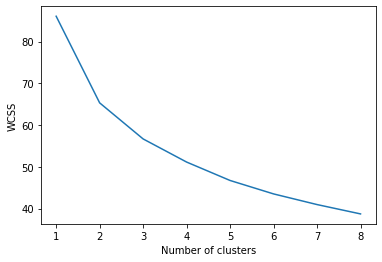

In [27]:
kmeans_elbow_plot(0)

Following the elbow plot above, I am going to choose 2 as the value of K.

In [28]:
group1 = kmeans_create_subgroup(0, k=2)

In [29]:
group1.head()

,id,group,review_1st,review_2nd,description_1st,description_2nd,overview_1st,overview_2nd,votes,reviews_from_critics,popularity,subgroup
0,tt0248123,1,0.809561,0.784496,0.450726,0.026841,0.841725,0.437456,0.738854,0.008197,0.000225,2
1,tt0443584,1,0.119524,0.424670,0.662225,0.261958,0.978468,0.143147,0.464968,0.012295,0.028406,2
2,tt0242527,1,0.384807,0.343383,0.740054,0.554190,0.817338,0.069299,0.700637,0.062842,0.023810,2
3,tt0374180,1,0.821214,0.161882,0.329482,0.479809,0.854410,0.196915,0.579618,0.043716,0.046704,1
4,tt0428856,1,0.672031,0.535561,0.473752,0.034677,0.912749,0.273534,0.713376,0.053279,0.029964,2


Later, to summurize our result, I am going to calculate the number of elements in each final group.

In [30]:
group_1_1 = group1[group1['subgroup'] == 1].shape[0]
group_1_2 = group1[group1['subgroup'] == 2].shape[0]

# Group 2(USA_English_Tobe Hooper_Horror) Clustering

In [31]:
csv_files[1]

'/Users/soyeon/Vanderbilt University/2021 Fall/case2/Data/cluster16_kmode/USA_English_Tobe Hooper_Horror.csv'

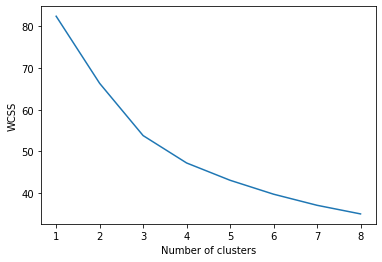

In [32]:
kmeans_elbow_plot(1)

In [33]:
group2 = kmeans_create_subgroup(1, k = 3)

In [34]:
group2.head()

,id,group,review_1st,review_2nd,description_1st,description_2nd,overview_1st,overview_2nd,votes,reviews_from_critics,popularity,subgroup
0,tt0051885,2,0.906268,0.178371,0.835506,0.404792,0.895216,0.080476,0.656051,0.028689,0.004527,1
1,tt0045992,2,0.655101,0.150205,0.713343,0.652042,0.813127,0.173266,0.732484,0.017760,0.002390,1
2,tt0114367,2,0.660765,0.502345,0.414357,0.894644,0.715754,0.139221,0.694268,0.092896,0.068940,3
3,tt0353489,2,0.910675,0.339227,0.350968,0.495396,0.915646,0.197972,0.700637,0.101093,0.019040,1
4,tt0115006,2,0.976296,0.449813,0.577182,0.859687,0.758705,0.120681,0.388535,0.025956,0.002215,3


In [35]:
group_2_1 = group2[group2['subgroup'] == 1].shape[0]
group_2_2 = group2[group2['subgroup'] == 2].shape[0]
group_2_3 = group2[group2['subgroup'] == 3].shape[0]

# Group 3(USA_English_Albert Pyun_Action) Clustering

In [36]:
csv_files[2]

'/Users/soyeon/Vanderbilt University/2021 Fall/case2/Data/cluster16_kmode/USA_English_Albert Pyun_Action.csv'

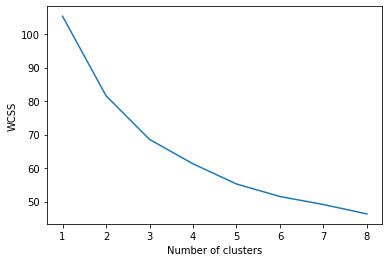

In [37]:
kmeans_elbow_plot(2)

In [38]:
group3 = kmeans_create_subgroup(2, k=3)

In [39]:
group3.head()

,id,group,review_1st,review_2nd,description_1st,description_2nd,overview_1st,overview_2nd,votes,reviews_from_critics,popularity,subgroup
0,tt0100263,3,0.672323,0.108523,0.864040,0.649300,0.865489,0.066118,0.808917,0.122951,0.035589,2
1,tt0029952,3,0.906517,0.610286,0.882157,0.568022,0.834124,0.106026,0.662420,0.005464,0.001092,2
2,tt0094375,3,0.336255,0.915459,0.254844,0.543080,0.763952,0.275084,0.707006,0.024590,0.004977,3
3,tt0118747,3,0.614170,0.094170,0.521744,0.122487,0.886363,0.304909,0.541401,0.068306,0.071120,2
4,tt0089087,3,0.762755,0.519844,0.708978,0.549799,0.827701,0.227118,0.783439,0.061475,0.105477,2


In [40]:
group_3_1 = group3[group3['subgroup'] == 1].shape[0]
group_3_2 = group3[group3['subgroup'] == 2].shape[0]
group_3_3 = group3[group3['subgroup'] == 3].shape[0]

# Group 4(USA_English, German_Tim Blake Nelson_Drama) Clustering

In [41]:
csv_files[3]

'/Users/soyeon/Vanderbilt University/2021 Fall/case2/Data/cluster16_kmode/USA_English, German_Tim Blake Nelson_Drama.csv'

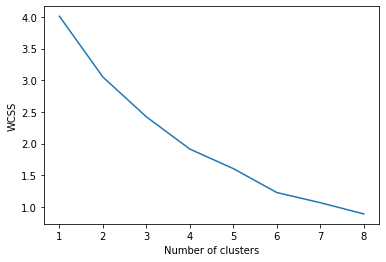

In [42]:
kmeans_elbow_plot(3)

In [43]:
group4 = kmeans_create_subgroup(3, k=2)

In [44]:
group4.head()

,id,group,review_1st,review_2nd,description_1st,description_2nd,overview_1st,overview_2nd,votes,reviews_from_critics,popularity,subgroup
0,tt0093201,4,0.636564,0.736984,0.667012,0.357170,0.833640,0.022593,0.522293,0.016393,0.000012,2
1,tt0450336,4,0.710691,0.407478,0.665571,0.562643,0.765015,0.223138,0.566879,0.103825,0.021967,2
2,tt0084445,4,0.540570,0.735997,0.544163,0.077749,0.917990,0.353135,0.668790,0.081967,0.007726,2
3,tt0074279,4,0.693998,0.577850,0.411326,0.393644,0.885203,0.197913,0.611465,0.040984,0.011329,2
4,tt0252480,4,0.834149,0.799770,0.188949,0.675300,0.745659,0.242494,0.745223,0.072404,0.017108,1


In [45]:
group_4_1 = group4[group4['subgroup'] == 1].shape[0]
group_4_2 = group4[group4['subgroup'] == 2].shape[0]

# Group 5(Australia_English_Alex Proyas_Comedy) Clustering

In [46]:
csv_files[4]

'/Users/soyeon/Vanderbilt University/2021 Fall/case2/Data/cluster16_kmode/Australia_English_Alex Proyas_Comedy.csv'

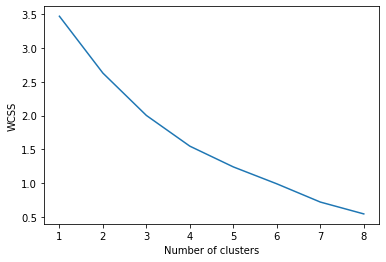

In [47]:
kmeans_elbow_plot(4)

In [48]:
group5 = kmeans_create_subgroup(4, k=2)

In [49]:
group5.head()

,id,group,review_1st,review_2nd,description_1st,description_2nd,overview_1st,overview_2nd,votes,reviews_from_critics,popularity,subgroup
0,tt0209368,5,0.370938,0.246846,0.540364,0.061175,0.949750,0.337695,0.643312,0.006831,0.004267,1
1,tt0086189,5,0.433576,0.445700,0.253633,0.667864,0.748705,0.209904,0.656051,0.017760,0.004518,2
2,tt0071282,5,0.466949,0.599314,0.607729,0.565620,0.879699,0.159369,0.579618,0.071038,0.010972,2
3,tt0118929,5,0.927706,0.120066,0.818034,0.145911,0.921348,0.116868,0.840764,0.293716,0.069444,1
4,tt0119415,5,0.723256,0.562921,0.267549,0.148351,0.848597,0.240678,0.445860,0.001366,0.001067,1


In [50]:
group_5_1 = group5[group5['subgroup'] == 1].shape[0]
group_5_2 = group5[group5['subgroup'] == 2].shape[0]

# Group 6(USA_English, French_Alan Bunce_Horror) Clustering

In [51]:
csv_files[5]

'/Users/soyeon/Vanderbilt University/2021 Fall/case2/Data/cluster16_kmode/USA_English, French_Alan Bunce_Horror.csv'

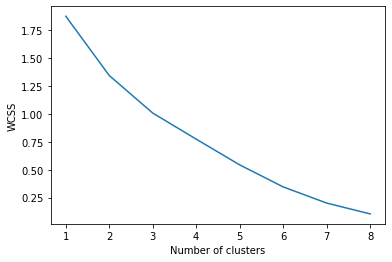

In [52]:
kmeans_elbow_plot(5)

In [53]:
group6 = kmeans_create_subgroup(5, k=1)

In [54]:
group6.head()

,id,group,review_1st,review_2nd,description_1st,description_2nd,overview_1st,overview_2nd,votes,reviews_from_critics,popularity,subgroup
0,tt0101414,6,0.830069,0.353316,0.408405,0.470326,0.802787,0.280523,0.885350,0.288251,0.126619,1
1,tt0073705,6,0.751460,0.371025,0.700618,0.186594,0.937582,0.097032,0.713376,0.142077,0.062358,1
2,tt0048289,6,0.810806,0.770780,0.810737,0.662326,0.861111,0.092616,0.598726,0.012295,0.004919,1
3,tt0096869,6,0.465306,0.679322,0.464117,0.626948,0.805744,0.287458,0.656051,0.004098,0.005132,1
4,tt0070578,6,0.086309,0.288606,0.894728,0.581012,0.874347,0.042076,0.598726,0.032787,0.000187,1


In [55]:
group_6_1 = group6[group6['subgroup'] == 1].shape[0]

# Group 7(USA_English_Mark Robson_Drama) Clustering

In [56]:
csv_files[6]

'/Users/soyeon/Vanderbilt University/2021 Fall/case2/Data/cluster16_kmode/USA_English_Mark Robson_Drama.csv'

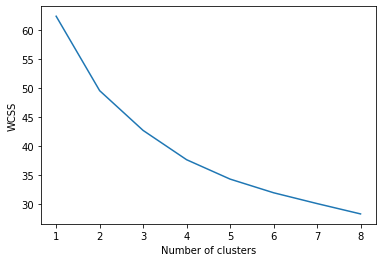

In [57]:
kmeans_elbow_plot(6)

In [58]:
group7 = kmeans_create_subgroup(6, k=2)

In [59]:
group7.head()

,id,group,review_1st,review_2nd,description_1st,description_2nd,overview_1st,overview_2nd,votes,reviews_from_critics,popularity,subgroup
0,tt0050652,7,0.588039,0.306144,0.640307,0.535378,0.811155,0.246075,0.694268,0.009563,0.000689,2
1,tt0082677,7,0.765101,0.662536,0.862908,0.580759,0.842537,0.131997,0.649682,0.069672,0.007877,2
2,tt0030287,7,0.501502,0.613235,0.525235,0.157638,0.965438,0.183288,0.834395,0.068306,0.060935,1
3,tt0036376,7,0.957032,0.116995,0.473780,0.178331,0.924406,0.167717,0.719745,0.079235,0.028870,1
4,tt0031742,7,0.496791,0.485055,0.571177,0.196271,0.892446,0.118902,0.866242,0.019126,0.005381,1


In [60]:
group_7_1 = group7[group7['subgroup'] == 1].shape[0]
group_7_2 = group7[group7['subgroup'] == 2].shape[0]

# Group 8(USA_English_Mikhail Kalatozov_Adventure) Clustering

In [61]:
csv_files[7]

'/Users/soyeon/Vanderbilt University/2021 Fall/case2/Data/cluster16_kmode/USA_English_Mikhail Kalatozov_Adventure.csv'

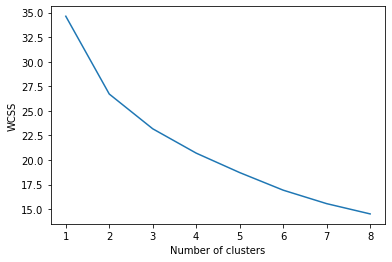

In [62]:
kmeans_elbow_plot(7)

In [63]:
group8 = kmeans_create_subgroup(7, k=2)

In [64]:
group8.head()

,id,group,review_1st,review_2nd,description_1st,description_2nd,overview_1st,overview_2nd,votes,reviews_from_critics,popularity,subgroup
0,tt0018515,8,0.792984,0.702751,0.245653,0.766920,0.759348,0.296303,0.324841,0.006831,0.002106,1
1,tt0067345,8,0.408970,0.320054,0.428419,0.745947,0.776805,0.153863,0.700637,0.021858,0.002443,1
2,tt0034182,8,0.787286,0.499831,0.751569,0.403780,0.857165,0.249826,0.745223,0.017760,0.005284,2
3,tt0024894,8,0.861651,0.134245,0.617550,0.595682,0.915516,0.066244,0.757962,0.125683,0.043518,1
4,tt0085750,8,0.744333,0.502810,0.513163,0.697166,0.776626,0.123148,0.401274,0.121585,0.089712,1


In [65]:
group_8_1 = group8[group8['subgroup'] == 1].shape[0]
group_8_2 = group8[group8['subgroup'] == 2].shape[0]

# Group 9(USA_English_Blake Edwards_Comedy) Clustering

In [66]:
csv_files[8]

'/Users/soyeon/Vanderbilt University/2021 Fall/case2/Data/cluster16_kmode/USA_English_Blake Edwards_Comedy.csv'

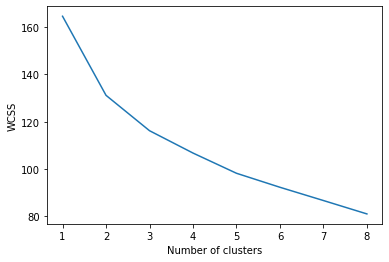

In [67]:
kmeans_elbow_plot(8)

In [68]:
group9 = kmeans_create_subgroup(8, k=2)

In [69]:
group9.head()

,id,group,review_1st,review_2nd,description_1st,description_2nd,overview_1st,overview_2nd,votes,reviews_from_critics,popularity,subgroup
0,tt0118866,9,0.298772,0.374605,0.628382,0.191606,0.918508,0.363543,0.668790,0.057377,0.010189,2
1,tt0115685,9,0.015606,0.300716,0.737798,0.226104,0.989704,0.201614,0.777070,0.105191,0.035120,2
2,tt0044811,9,0.205846,0.191588,0.589875,0.166897,0.923672,0.324091,0.726115,0.019126,0.004061,2
3,tt0466766,9,0.863554,0.280539,0.577218,0.605527,0.813284,0.078678,0.503185,0.034153,0.009602,1
4,tt0122933,9,0.666472,0.184731,0.858381,0.379327,0.822882,0.363266,0.732484,0.183060,0.041249,1


In [70]:
group_9_1 = group9[group9['subgroup'] == 1].shape[0]
group_9_2 = group9[group9['subgroup'] == 2].shape[0]

# Group 10(USA_English_Joseph L. Mankiewicz_Crime) Clustering

In [71]:
csv_files[9]

'/Users/soyeon/Vanderbilt University/2021 Fall/case2/Data/cluster16_kmode/USA_English_Joseph L. Mankiewicz_Crime.csv'

In [72]:
kmeans_elbow_plot(9)

ValueError: n_samples=2 should be >= n_clusters=3.

Oh, it returns an error! Let's see the original data to examine what the problem is.

In [ ]:
pd.read_csv(csv_files[9])

Since the group has only 2 elements, K-means clustering cannot be performed on this group. Let's not use this group.

# Group 11(Japan_Japanese_Akira Kurosawa_Animation) Clustering

In [ ]:
csv_files[10]

In [ ]:
kmeans_elbow_plot(10)

In [73]:
group10 = kmeans_create_subgroup(10, k=3)
group10["group"] = 10

In [74]:
group10.head()

,id,group,review_1st,review_2nd,description_1st,description_2nd,overview_1st,overview_2nd,votes,reviews_from_critics,popularity,subgroup
0,tt0065755,10,0.756809,0.470807,0.450287,0.836195,0.752243,0.126973,0.605096,0.056011,0.000036,2
1,tt0235712,10,0.442717,0.118079,0.392469,0.369931,0.892023,0.086297,0.649682,0.073770,0.027055,3
2,tt0831888,10,0.457365,0.710846,0.530888,0.642448,0.818548,0.164011,0.872611,0.079235,0.037935,2
3,tt0120408,10,0.346268,0.400369,0.853297,0.362581,0.735779,0.314755,0.770701,0.058743,0.005914,1
4,tt0158714,10,0.527040,0.796825,0.746312,0.301619,0.734345,0.309143,0.885350,0.157104,0.039058,1


In [75]:
group_11_1 = group10[group10['subgroup'] == 1].shape[0]
group_11_2 = group10[group10['subgroup'] == 2].shape[0]
group_11_3 = group10[group10['subgroup'] == 3].shape[0]

# Group 12(USA_English_Charles Jarrott_Biography) Clustering

In [76]:
csv_files[11]

'/Users/soyeon/Vanderbilt University/2021 Fall/case2/Data/cluster16_kmode/USA_English_Charles Jarrott_Biography.csv'

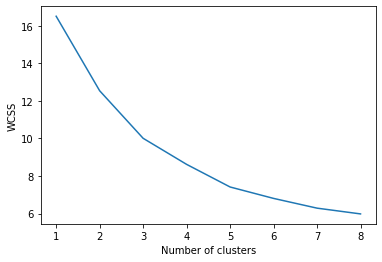

In [77]:
kmeans_elbow_plot(11)

In [78]:
group11 = kmeans_create_subgroup(11, k=3)
group11["group"] = 11

In [79]:
group11.head()

,id,group,review_1st,review_2nd,description_1st,description_2nd,overview_1st,overview_2nd,votes,reviews_from_critics,popularity,subgroup
0,tt0073496,11,0.322174,0.200904,0.472221,0.186062,0.905646,0.032059,0.656051,0.002732,0.000213,1
1,tt0071746,11,0.529312,0.259755,0.186741,0.466427,0.829823,0.341740,0.840764,0.086066,0.039367,1
2,tt0101578,11,0.414465,0.789208,0.313536,0.490535,0.760353,0.330588,0.687898,0.002732,0.000813,2
3,tt0119586,11,0.326589,0.186633,0.206197,0.328361,0.830099,0.414388,0.694268,0.032787,0.006064,1
4,tt0098219,11,0.716832,0.775446,0.245662,0.459116,0.823001,0.255546,0.777070,0.013661,0.011826,2


In [80]:
group_12_1 = group11[group11['subgroup'] == 1].shape[0]
group_12_2 = group11[group11['subgroup'] == 2].shape[0]
group_12_3 = group11[group11['subgroup'] == 3].shape[0]

# Group 13(USA_English_Fritz Lang_Crime) Clustering

In [81]:
csv_files[12]

'/Users/soyeon/Vanderbilt University/2021 Fall/case2/Data/cluster16_kmode/USA_English_Fritz Lang_Crime.csv'

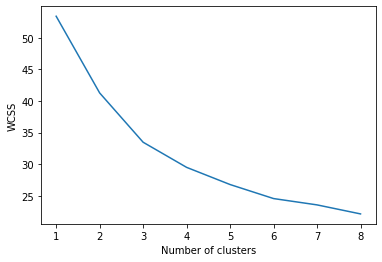

In [82]:
kmeans_elbow_plot(12)

In [83]:
group12 = kmeans_create_subgroup(12, k=3)
group12["group"] = 12

In [84]:
group12.head()

,id,group,review_1st,review_2nd,description_1st,description_2nd,overview_1st,overview_2nd,votes,reviews_from_critics,popularity,subgroup
0,tt0112443,12,0.525297,0.520421,0.767956,0.724207,0.810570,0.174551,0.554140,0.017760,0.004930,2
1,tt0084732,12,0.648486,0.097900,0.916698,0.484419,0.875263,0.126149,0.675159,0.034153,0.020340,3
2,tt0221218,12,0.395685,0.198193,0.628770,0.024888,0.919410,0.245117,0.611465,0.136612,0.034684,1
3,tt0046878,12,0.635641,0.140246,0.758477,0.554044,0.900043,0.104158,0.783439,0.062842,0.017358,3
4,tt0161292,12,0.636992,0.667674,0.352434,0.082761,0.933241,0.319661,0.783439,0.049180,0.016192,1


In [85]:
group_13_1 = group12[group12['subgroup'] == 1].shape[0]
group_13_2 = group12[group12['subgroup'] == 2].shape[0]
group_13_3 = group12[group12['subgroup'] == 3].shape[0]

# Group 14(USA_English_Fritz Lang_Crime) Clustering

In [86]:
csv_files[13]

'/Users/soyeon/Vanderbilt University/2021 Fall/case2/Data/cluster16_kmode/USA_English_Harry Basil_Comedy.csv'

In [87]:
kmeans_elbow_plot(13)

ValueError: n_samples=1 should be >= n_clusters=2.

Oh, it returns an error! Let's see the original data to examine what the problem is.

In [88]:
pd.read_csv(csv_files[13])

,id,review_1st,review_2nd,description_1st,description_2nd,overview_1st,overview_2nd,votes,reviews_from_critics,popularity,recommendation1,recommendation2,recommendation3,recommendation4,recommendation5,recommendation6
0,tt0403946,0.438067,11.663147,18.994333,-3.26644,11.685879,3.003973,4.2,6.0,2.266472,NaN,NaN,NaN,NaN,NaN,NaN


Since the group has only 1 element, K-means clustering cannot be performed on this group. Let's not use this group.

# Group 15(USA_English_Fritz Lang_Crime) Clustering

In [89]:
csv_files[14]

'/Users/soyeon/Vanderbilt University/2021 Fall/case2/Data/cluster16_kmode/USA_English_Joel Silberg_Comedy.csv'

In [90]:
kmeans_elbow_plot(14)

ValueError: n_samples=1 should be >= n_clusters=2.

Oh, it returns an error! Let's see the original data to examine what the problem is.

In [91]:
pd.read_csv(csv_files[14])

,id,review_1st,review_2nd,description_1st,description_2nd,overview_1st,overview_2nd,votes,reviews_from_critics,popularity,recommendation1,recommendation2,recommendation3,recommendation4,recommendation5,recommendation6
0,tt0086998,4.052832,12.53694,19.587532,-3.268003,13.527758,1.889188,5.8,31.0,2.598283,tt0089444,NaN,NaN,NaN,NaN,NaN


Since the group has only 1 element, K-means clustering cannot be performed on this group. Let's not use this group.

# Group 16(USA_English, German_Leslie Fenton_Drama) Clustering

In [92]:
csv_files[15]

'/Users/soyeon/Vanderbilt University/2021 Fall/case2/Data/cluster16_kmode/USA_English, German_Leslie Fenton_Drama.csv'

In [93]:
kmeans_elbow_plot(15)

ValueError: n_samples=1 should be >= n_clusters=2.

Oh, it returns an error! Let's see the original data to examine what the problem is.

In [94]:
pd.read_csv(csv_files[15])

,id,review_1st,review_2nd,description_1st,description_2nd,overview_1st,overview_2nd,votes,reviews_from_critics,popularity,recommendation1,recommendation2,recommendation3,recommendation4,recommendation5,recommendation6
0,tt0037386,5.223167,14.189524,17.36336,-1.299123,8.347475,2.56148,6.5,12.0,0.469587,tt0041247,tt0038107,NaN,NaN,NaN,NaN


Since the group has only 1 element, K-means clustering cannot be performed on this group. Let's not use this group.

In [95]:
### print('The 1st group has 2 subgroup')
print('The 1st group has 2 subgroups')
print('\tThe size of 1st subgroup is ' + str(group_1_1))
print('\tThe size of 1st subgroup is ' + str(group_1_2))
print('-----------------')
print('The 2nd group has 3 subgroups')
print('\tThe size of 1st subgroup is ' + str(group_2_1))
print('\tThe size of 2nd subgroup is ' + str(group_2_2))
print('\tThe size of 3rd subgroup is ' + str(group_2_3))
print('-----------------')
print('The 3rd group has 3 subgroups')
print('\tThe size of 1st subgroup is ' + str(group_3_1))
print('\tThe size of 2nd subgroup is ' + str(group_3_2))
print('\tThe size of 3rd subgroup is ' + str(group_3_3))
print('-----------------')
print('The 4th group has 2 subgroups')
print('\tThe size of 1st subgroup is ' + str(group_4_1))
print('\tThe size of 2nd subgroup is ' + str(group_4_2))
print('-----------------')
print('The 5th group has 2 subgroups')
print('\tThe size of 1st subgroup is ' + str(group_5_1))
print('\tThe size of 2nd subgroup is ' + str(group_5_2))
print('-----------------')
print('The 6th group has 1 subgroup')
print('\tThe size of 1st subgroup is ' + str(group_6_1))
print('-----------------')
print('The 7th group has 2 subgroups')
print('\tThe size of 1st subgroup is ' + str(group_7_1))
print('\tThe size of 2nd subgroup is ' + str(group_7_2))
print('-----------------')
print('The 8th group has 2 subgroups')
print('\tThe size of 1st subgroup is ' + str(group_8_1))
print('\tThe size of 2nd subgroup is ' + str(group_8_2))
print('-----------------')
print('The 9th group has 2 subgroups')
print('\tThe size of 1st subgroup is ' + str(group_9_1))
print('\tThe size of 2nd subgroup is ' + str(group_9_2))
print('-----------------')
print('The 10th group has 3 subgroups')
print('\tThe size of 1st subgroup is ' + str(group_11_1))
print('\tThe size of 2nd subgroup is ' + str(group_11_2))
print('\tThe size of 3rd subgroup is ' + str(group_11_3))
print('-----------------')
print('The 11th group has 3 subgroups')
print('\tThe size of 1st subgroup is ' + str(group_12_1))
print('\tThe size of 2nd subgroup is ' + str(group_12_2))
print('\tThe size of 3rd subgroup is ' + str(group_12_3))
print('-----------------')
print('The 12th group has 3 subgroups')
print('\tThe size of 1st subgroup is ' + str(group_13_1))
print('\tThe size of 2nd subgroup is ' + str(group_13_2))
print('\tThe size of 3rd subgroup is ' + str(group_13_3))
print('-----------------')

The 1st group has 2 subgroups
	The size of 1st subgroup is 150
	The size of 1st subgroup is 242
-----------------
The 2nd group has 3 subgroups
	The size of 1st subgroup is 145
	The size of 2nd subgroup is 110
	The size of 3rd subgroup is 105
-----------------
The 3rd group has 3 subgroups
	The size of 1st subgroup is 154
	The size of 2nd subgroup is 169
	The size of 3rd subgroup is 152
-----------------
The 4th group has 2 subgroups
	The size of 1st subgroup is 10
	The size of 2nd subgroup is 8
-----------------
The 5th group has 2 subgroups
	The size of 1st subgroup is 7
	The size of 2nd subgroup is 8
-----------------
The 6th group has 1 subgroup
	The size of 1st subgroup is 11
-----------------
The 7th group has 2 subgroups
	The size of 1st subgroup is 180
	The size of 2nd subgroup is 133
-----------------
The 8th group has 2 subgroups
	The size of 1st subgroup is 95
	The size of 2nd subgroup is 72
-----------------
The 9th group has 2 subgroups
	The size of 1st subgroup is 339
	Th

# Combine all dataframes.

So far, all groups are seperated by the result of K-mode. For next step, I am going to merge all these group data.

In [96]:
total_group = [group1, group2, group3, group4, group5, group6, group7, group8, group9, group10, group11, group12]
final_df = pd.concat(total_group)

In [97]:
final_df = final_df[["id", "group", "subgroup", "review_1st", "review_2nd", "description_1st", "description_2nd", "overview_1st", "overview_2nd", "votes", "reviews_from_critics", "popularity"]]

In [98]:
final_df.head()

,id,group,subgroup,review_1st,review_2nd,description_1st,description_2nd,overview_1st,overview_2nd,votes,reviews_from_critics,popularity
0,tt0248123,1,2,0.809561,0.784496,0.450726,0.026841,0.841725,0.437456,0.738854,0.008197,0.000225
1,tt0443584,1,2,0.119524,0.424670,0.662225,0.261958,0.978468,0.143147,0.464968,0.012295,0.028406
2,tt0242527,1,2,0.384807,0.343383,0.740054,0.554190,0.817338,0.069299,0.700637,0.062842,0.023810
3,tt0374180,1,1,0.821214,0.161882,0.329482,0.479809,0.854410,0.196915,0.579618,0.043716,0.046704
4,tt0428856,1,2,0.672031,0.535561,0.473752,0.034677,0.912749,0.273534,0.713376,0.053279,0.029964


In [99]:
final_df.to_csv(prefix_path + personal_path + 'case2/Data/yesVotes_kmode_kmeans_final_df.csv')